In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
from p_tqdm import p_map
import librosa
import librosa.display
import random
from skimage.transform import resize
import warnings


In [2]:
warnings.filterwarnings('ignore')

### LISTAGE DES FICHIERS CONTENUS DANS LE DATASET

In [3]:
def get_audio_list(location = "/home/george/code/clumzy/electronic_tagger/datasets/audio_files", max_samples = 250, random_state = 420):
    audio_files = np.empty((0,3))
    # LES EXTENSIONS QUE L'ON CHERCHE
    exts = ['*.mp3', '*.aiff', '*.flac','*.wav']
    # LES DIFFERENTS SOUS-DOSSIERS (ON NE VERIFIE PAS QU'ILS CONTIENNENT DES ELEMENTS)
    sub_directories = [f.path for f in os.scandir(location) if f.is_dir()]
    for directory in sub_directories:
        # ON LISTE LES FICHIERS AUDIO TROUVES DANS LE SUB DIR
        sub_dir_files = [f for ext in exts for f in glob(os.path.join(directory, ext))]
        if len(sub_dir_files) > 0:
            # ON SEED
            random.seed(random_state)
            # ON MELANGE
            random.shuffle(sub_dir_files)
            # ON DUPLIQUE LES FICHIERS SI IL Y EN A PAS ASSEZ
            while len(sub_dir_files) < max_samples : sub_dir_files = sub_dir_files + sub_dir_files[:max_samples-len(sub_dir_files)]
            # ON RECUPERE DES SAMPLES
            sub_dir_samples = random.sample(sub_dir_files, k=max_samples)
            for sample in sub_dir_samples:
                #ON RENVOIE
                # 0 - CHEMIN DU FICHIER
                # 1 - GENRE
                # 2 - NOMBRE DE FOIS OU IL APPARAIT AFIN DE BIEN METTRE UN OFFSET
                audio_files = np.append(audio_files, [[sample, os.path.basename(directory), np.count_nonzero(audio_files[-len(sub_dir_files):] == sample)]], axis=0)
    return audio_files            


### FEATURE MAKER FUNCTION & SCALER FUNCTION

Ces fonctions nous servent à scaler et créer **l'image feature** pour un fichier donné.

In [4]:
import pydub

def rgb_transform(data):
    """Une fonction qui prend en entrée une image au format Array en RGB, et qui va normaliser
    selon une formule MinMax scalée sur 255.

    Args:
        data (numpy.array): Une image au format numpy Array.

    Returns:
        numpy.array: L'image normalisée.
    """
    return (((data+abs(data.min()))/(data+abs(data.min())).max())*255).astype(np.uint8)

def get_from_pydub(file, normalized=True, num_sample=10, sample_length=3, sample_rate=44100, offset = 0, max_offset = 0):
    """Une fonction qui renvoie un array Numpy représentant un fichier audio découpé selon
    les paramètres indiqués dans la fonction. On anticipe aussi le fait de récupérer plusieurs fois
    le même son, avec la capacité de procéder à un offset. Les différents extraits sont équitablement répartis
    dans le fichier audio.

    Args:
        file (str): L'emplacement du fichier son.
        normalized (bool, optional): Le marqueur de normalisation de l'amplitude du son. Defaults to True.
        num_sample (int, optional): Le nombre de samples pour la découpe. Defaults to 5.
        sample_length (int, optional): La longueur des samples découpés. Defaults to 6.
        sample_rate (int, optional): Le sampling rate du fichier audio. Defaults to 44100.
        offset (int, optional): Le décalage (de sample_length) des différents samples. Defaults to 0.
        max_offset (int, optional): Le nombre maximum de décalages pour ce fichier. Defaults to 2.

    Returns:
        numpy.array: Un array Numpy représentant nos différents extraits.
    """
    NUM_SAMPLE = num_sample
    SAMPLING_RATE = sample_rate
    MAX_OFFSET = max_offset+1
    if MAX_OFFSET-offset <= 0:
        print(f"WARNING, OFFSET {offset} is TOO BIG")
    OFFSET = offset
    song = pydub.AudioSegment.from_file_using_temporary_files(file).set_channels(1)
    #ON REMET LE SAMPLE RATE A 44100 SI CE N'EST PAS LE CAS
    if song.frame_rate != SAMPLING_RATE: song = song.set_frame_rate(sample_rate)
    SAMPLE_LENGTH = sample_length*1000
    # LA CHANSON EST DECOUPEE EN NUM_SAMPLES MORCEAUX, DE LONGEUR SAMPLE_LENGTH(SECONDES)
    song_inter = np.linspace(SAMPLE_LENGTH*(MAX_OFFSET-OFFSET-1)+(1*1000),len(song)-(SAMPLE_LENGTH*(MAX_OFFSET-OFFSET)+(10*1000)),NUM_SAMPLE).astype(int)
    y = np.hstack([song[song_inter[i]:song_inter[i]+SAMPLE_LENGTH].get_array_of_samples() for i in range(0,NUM_SAMPLE)])
    # ON RENVOIE UNE VERSION NORMALISEE DE L'AMPLITUDE
    if normalized:
        return song.frame_rate, np.float32(y) / 2**15
    else:
        return song.frame_rate, y

def song_to_img(file, hop_length=1024, num_sample=10, sample_length=3, sample_rate=44100, offset = 0, max_offset=0):
    """Une fonction qui transforme un fichier audio en image.
    L'image renvoyée est composée du 
        - Constant_Q
        - MFCC (26 bins)
        - Chromagram (36 bins)

    Args:
        file (str): L'emplacement du fichier son.
        hop_length (int, optional): La taille de la fenêtre utilisée pour l'analyse. Defaults to 1024.
        num_sample (int, optional): Le nombre de samples pour la découpe. Defaults to 10.
        sample_length (int, optional): La longueur des samples découpés. Defaults to 3.
        sample_rate (int, optional): Le sampling rate du fichier audio. Defaults to 44100.
        offset (int, optional): Le décalage (de sample_length) des différents samples. Defaults to 0.
        max_offset (int, optional): Le nombre maximum de décalages pour ce fichier. Defaults to 0.

    Returns:
        numpy.array: Une image au format numpy Array, en RGB.
    """
    # VALEUR TEMPORAIRE DE HAUTEUR D'IMAGE, A REVOIR PLUS TARD /!\
    warnings.filterwarnings('ignore')
    HOP_LENGTH = hop_length
    NUM_SAMPLE = num_sample
    SAMPLE_LENGTH = sample_length
    SAMPLING_RATE = sample_rate
    OFFSET = int(offset)
    MAX_OFFSET = int(max_offset)
    pydub_sr, song_extracts = get_from_pydub(
        file, 
        normalized=True,
        num_sample=NUM_SAMPLE,
        sample_length=SAMPLE_LENGTH,
        sample_rate=SAMPLING_RATE,
        offset = OFFSET,
        max_offset = MAX_OFFSET)
    # ON AFFICHE UN AVERTISSEMENT SI LE SAMPLING RATE N'EST PAS BON

    #CALCUL DU CONSTANT Q
    constant_q_temp = librosa.cqt(song_extracts, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
    constant_q = librosa.amplitude_to_db(np.abs(constant_q_temp))
    
    #CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
    ## CE FEATURE NE MARCHE PAS TRES BIEN /!\
    mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=26, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

    #CALCUL DU CHROMAGRAMME (LES NOTES)
    ## VERSION CENS
    chromacens = librosa.feature.chroma_cens(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=36, win_len_smooth=5, C=constant_q_temp)
    #CREATION DE LA SHAPE FINALE A PARTIR DES PLUS GRANDES VALEURS DE NOS TROIS FEATURES
    IM_HEIGHT = max(constant_q.shape[0], mfcc_song.shape[0], chromacens.shape[0])
    IM_WIDTH = max(constant_q.shape[1], mfcc_song.shape[1], chromacens.shape[1])
    IM_SHAPE = (IM_HEIGHT, IM_WIDTH)

    r = rgb_transform(resize(constant_q, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    g = rgb_transform(resize(mfcc_song, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    b = rgb_transform(resize(chromacens, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)
    
    rgb = np.dstack((r,g,b)).astype(np.uint8)
    return rgb

### EXEMPLE D'UNE CREATION DE FEATURES

In [9]:
SONG_NUM = 2
audio_files = get_audio_list(max_samples=5)

img = song_to_img(
    audio_files[SONG_NUM,0], 
    hop_length=1024,
    num_sample = 10,
    sample_length=3,
    sample_rate = 44100,
    offset = 0,
    max_offset=0)
print(img.shape)
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

(84, 1292, 3)


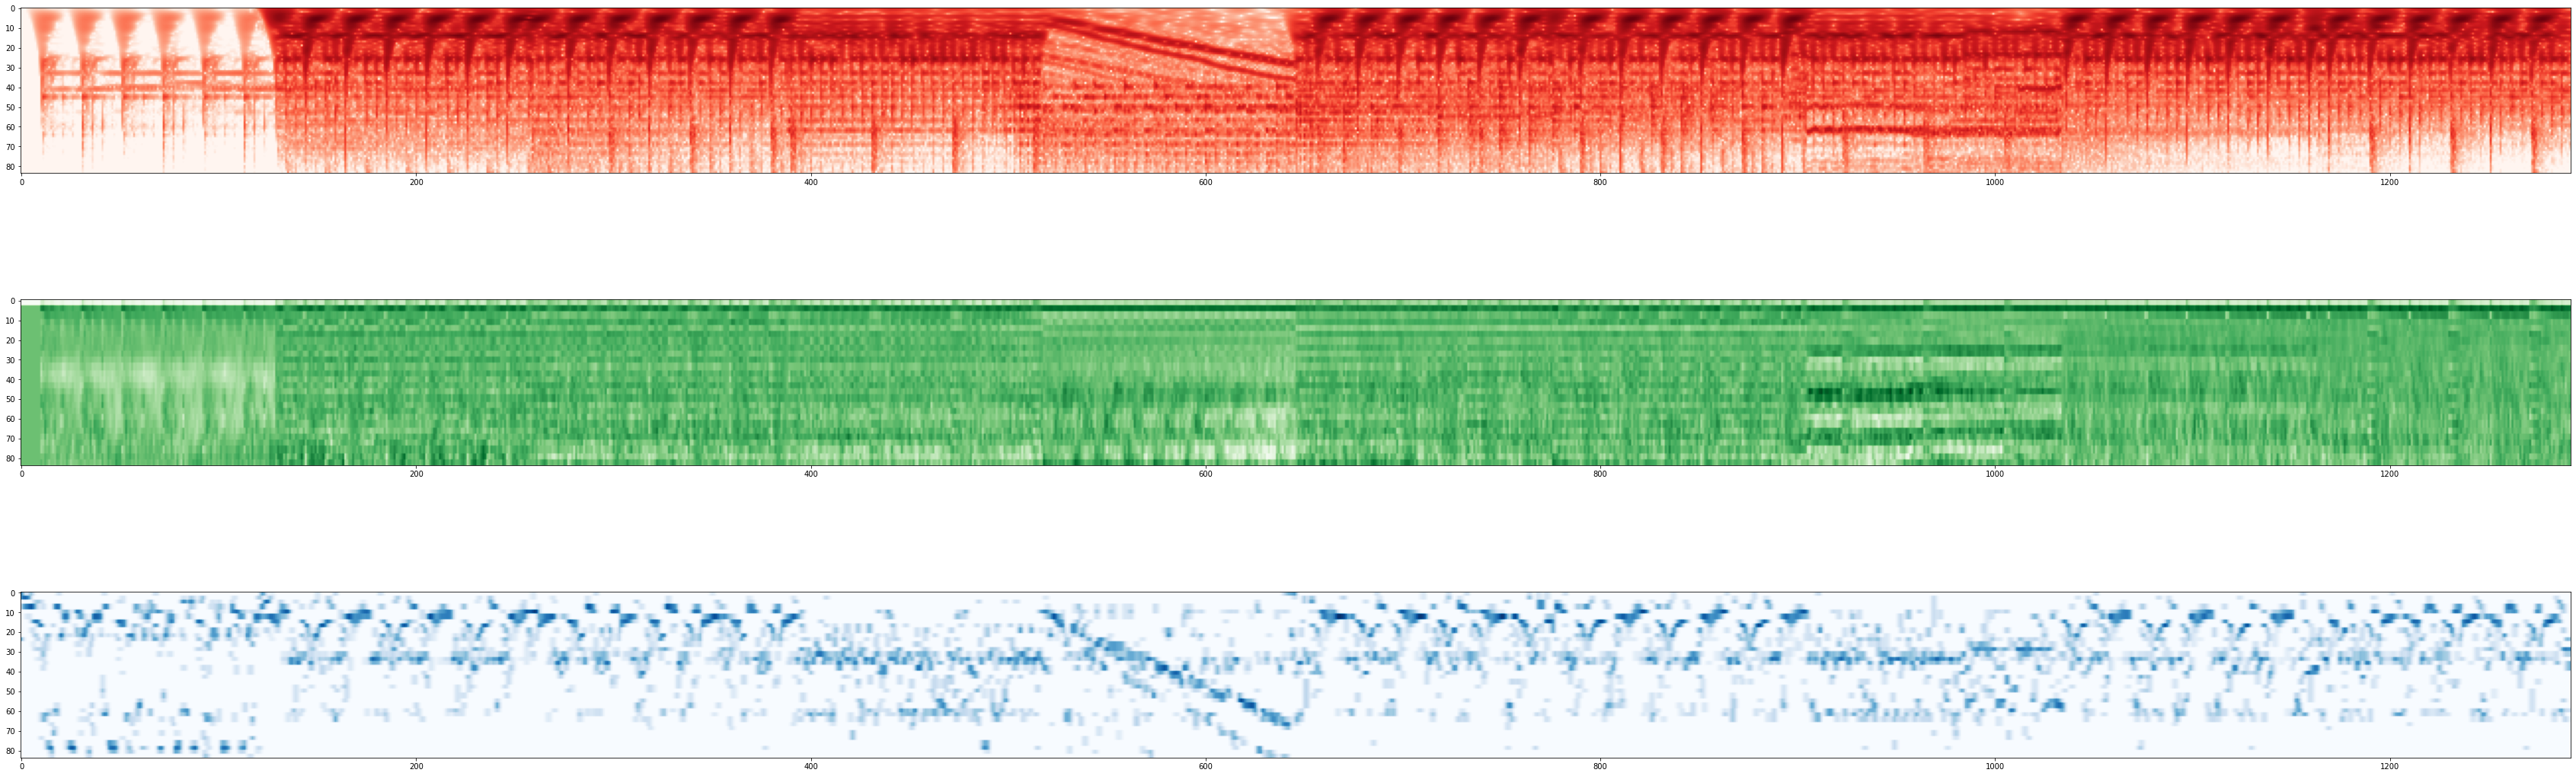

In [10]:
plt.figure(figsize=(60,20))
plt.subplot(3,1,1)
plt.imshow((r), cmap="Reds")
plt.subplot(3,1,2)
plt.imshow(g, cmap="Greens")
plt.subplot(3,1,3)
plt.imshow(b, cmap="Blues")
plt.show()

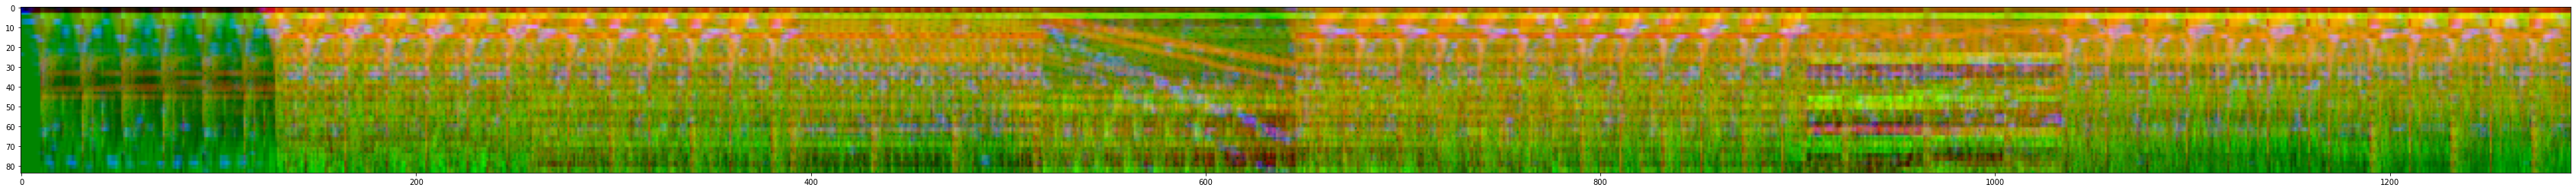

In [11]:
rgb = np.dstack((r,g,b))
plt.figure(figsize=(60,8))
plt.imshow(rgb)

### CREATION DES FEATURES POUR LA LISTE DES MUSIQUES

In [6]:
audio_files = get_audio_list(max_samples=500)
HOW_MANY = len(audio_files)
MAX_OFFSET = np.max(audio_files[:, 2].astype(int))
X = np.array(p_map(
    song_to_img,
    audio_files[:, 0],
    [1024]*HOW_MANY,
    [10]*HOW_MANY,
    [3]*HOW_MANY,
    [44100]*HOW_MANY,
    audio_files[:, 2],
    [MAX_OFFSET]*HOW_MANY), dtype=np.uint8)
print(X.shape)

y = audio_files


100%|██████████| 10500/10500 [2:04:23<00:00,  1.41it/s] 


(10500, 84, 1292, 3)


### EXPORT DES FEATURES

In [7]:
import pickle
pickle.dump(X, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big.pkl"), "wb" ) )
pickle.dump(y, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","target3_big.pkl"), "wb" ) )

In [8]:
X1 = X[:2625]
X2 = X[2625:5250]
X3 = X[5250:7875]
X4 = X[7875:]
pickle.dump(X1, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part1.pkl"), "wb" ) )
pickle.dump(X2, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part2.pkl"), "wb" ) )
pickle.dump(X3, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part3.pkl"), "wb" ) )
pickle.dump(X4, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images3_big_part4.pkl"), "wb" ) )